In [122]:
import os
from PIL import Image
from typing import Optional, Callable

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode


'''
TRAIN
 {ID}/images/
 {ID}/{ID}_boxes.txt
 [file_name, bbox(l, t, w, h)]
 
VALID
 /images/
 val_annotations.txt
 [file_name, label, bbox(l, t, w, h)]
'''


class TinyImagenet200(Dataset):
    def __init__(self,
                 annotations_file: str,
                 img_dir: str,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(annotations_file, delimiter='\t')
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # forced to read in rbg because there exist gray image.
        # TODO
        #  - filter gray image in sampler or collate_fn
        # shape of image: [C, H, W]
        image = read_image(img_path, mode=ImageReadMode.RGB)
        image = image.permute(1, 2, 0)
        image = Image.fromarray(image.numpy())
        
        # class label id (string type)
        label = self.img_labels.iloc[idx, 1]

        # read_imate returns torch.Tensor type of image
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

class LabelTransform:
    def __init__(self, label_file: str = None):
        label_data = pd.read_csv(label_file, header=None, delimiter='\t')
        self.idx_to_label_name = []
        for label_name in label_data.iloc[:, 1]:
            self.idx_to_label_name.append(label_name)
            
        self.label_id_to_idx = {}
        for idx, label_id in enumerate(label_data.iloc[:, 0]):
            self.label_id_to_idx[label_id] = idx
    
    def __call__(self, label_id):
        return self.label_id_to_idx[label_id]

    def label_name(self, idx):
        assert idx < len(self.idx_to_label_name)
        return self.idx_to_label_name[idx]

label_file = './data/tiny-imagenet-200/tiny-imagenet-200.txt'
target_transform = LabelTransform(label_file)
print(target_transform('n01945685'))
print(target_transform.label_name(0))


100
Egyptian cat


# Preparing TinyImagenet200 data for training with DataLoaders

In [123]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

data_root = '/home/btb/hd/data/tiny-imagenet-200'
train_anno_file = os.path.join(data_root, 'train_annotations.txt')
train_img_root = os.path.join(data_root, 'train')
training_data = TinyImagenet200(
    annotations_file=train_anno_file,
    img_dir=train_img_root,
    transform=ToTensor(),
    target_transform=target_transform
)

test_anno_file = os.path.join(data_root, 'val', 'val_annotations.txt')
test_img_root = os.path.join(data_root, 'val', 'images')
test_data = TinyImagenet200(
    annotations_file=train_anno_file,
    img_dir=train_img_root,
    transform=ToTensor(),
    target_transform=target_transform
)

In [124]:
from torch.utils.data import RandomSampler

train_sampler = RandomSampler(training_data)
train_dataloader = DataLoader(training_data,
                              sampler=train_sampler,
                              batch_size=8,
                              pin_memory=True)

test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [125]:
images, labels = next(iter(train_dataloader))
print(len(images))
print(type(images))
print(type(labels))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
8
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Files already downloaded and verified


Training (X / X Steps) (loss=X.X):   0%|| 0/6250 [00:00<?, ?it/s]


<class 'tuple'>


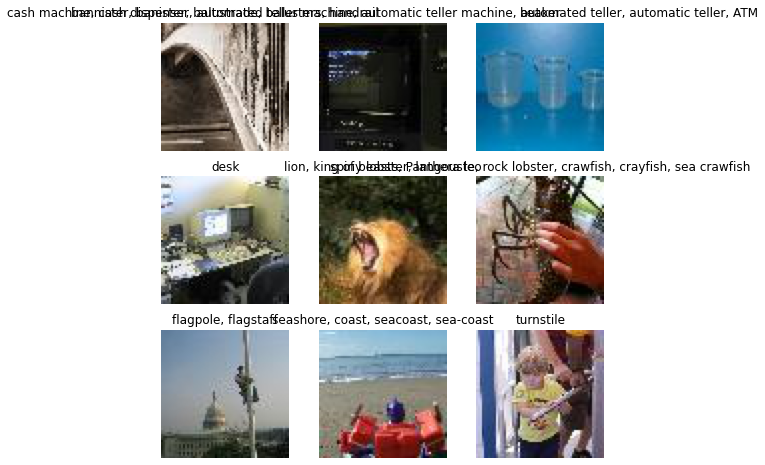

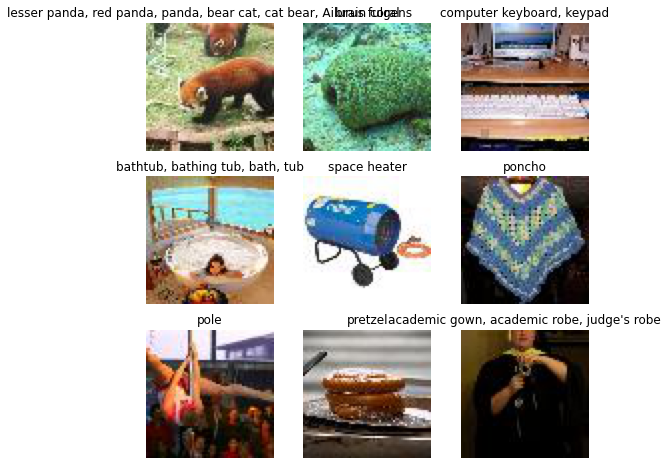

In [94]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

label_map_file = os.path.join(data_root, 'tiny-imagenet-200.txt')
import csv
label_map = {}
with open(label_map_file, newline='') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        label_map[row[0]] = row[1]

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()


figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    img = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

# CIFAR10 Train Test

In [78]:
from torchvision import transforms, datasets


transform_train = transforms.Compose([
        transforms.RandomResizedCrop((224, 224), scale=(0.05, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

trainset = datasets.CIFAR10(root="./data",
                                    train=True,
                                    download=True,
                                    transform=transform_train)

train_sampler = RandomSampler(trainset)
train_loader = DataLoader(trainset,
                              sampler=train_sampler,
                              batch_size=8,
                              num_workers=4,
                              pin_memory=True)

epoch_iterator = tqdm(train_loader,
                              desc="Training (X / X Steps) (loss=X.X)",
                              bar_format="{l_bar}{r_bar}",
                              dynamic_ncols=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
step, batch = next(enumerate(epoch_iterator))
batch = tuple(t.to(device) for t in batch)
print(batch[1])

Files already downloaded and verified


Training (X / X Steps) (loss=X.X):   0%|| 0/6250 [00:00<?, ?it/s]

tensor([5, 7, 8, 9, 4, 8, 2, 5], device='cuda:0')


# Train Test

In [77]:
from tqdm import tqdm

epoch_iterator = tqdm(train_dataloader,
                      desc="Training (X / Y Steps) (loss=X.X)",
                      bar_format="{l_bar}{r_bar}",
                      dynamic_ncols=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
step, batch = next(enumerate(epoch_iterator))
batch = tuple(t.to(device) for t in batch)
print(type(batch))
# for step, batch in enumerate(epoch_iterator):
#     print(type(batch))
    # batch = tuple(t.to(device) for t in batch)

Training (X / Y Steps) (loss=X.X):   0%|| 0/12500 [00:00<?, ?it/s]

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


AttributeError: 'list' object has no attribute 'to'

# Train Label Convert

In [22]:
import os

data_root = '/home/btb/hd/data/tiny-imagenet-200'

wnids_file = os.path.join(data_root, 'wnids.txt')
words_file = os.path.join(data_root, 'words.txt')

import csv

with open(wnids_file) as wnids_fd:
    wnids = wnids_fd.readlines()
wnids = [ids.replace('\n', '') for ids in wnids]

words_dict = {}
with open(words_file, newline='') as words_fd:
    words_reader = csv.reader(words_fd, delimiter='\t')
    for row in words_reader:
        words_dict[row[0]] = row[1]

words_200 = []
for id in wnids:
    words_200.append([id, words_dict[id]])

words_200_file = os.path.join(data_root, 'tiny-imagenet-200-label-map.txt')
with open(words_200_file, 'w', newline='') as sets_fd:
    writer = csv.writer(sets_fd, delimiter='\t')
    writer.writerows(words_200)

# Convert Train Data Info

In [34]:
import os

data_root = '/home/btb/hd/data/tiny-imagenet-200'

wnids_file = os.path.join(data_root, 'wnids.txt')
words_file = os.path.join(data_root, 'words.txt')

import csv

with open(wnids_file) as wnids_fd:
    wnids = wnids_fd.readlines()
wnids = [ids.replace('\n', '') for ids in wnids]

new_annotations = []
for id in wnids:
    img_root = os.path.join(id, 'images')
    data_path = os.path.join(data_root, 'train', id)
    train_label_file = os.path.join(data_path, f'{id}_boxes.txt')
    
    with open(train_label_file, newline='') as csv_fd:
        label_reader = csv.reader(csv_fd, delimiter='\t')
        for row in label_reader:
            img_path = os.path.join(img_root, row[0])
            new_annotations.append([img_path, id, row[1], row[2], row[3], row[4]])

print(len(new_annotations))
train_anno_file = os.path.join(data_root, 'train_annotations.txt')
with open(train_anno_file, 'w', newline='') as sets_fd:
    writer = csv.writer(sets_fd, delimiter='\t')
    writer.writerows(new_annotations)

100000


# Pandas Read CSV Test

In [41]:
import pandas as pd

labels = pd.read_csv(train_anno_file, delimiter='\t')
print(labels.iloc[0, :])

n02124075/images/n02124075_0.JPEG    n02124075/images/n02124075_1.JPEG
n02124075                                                    n02124075
1                                                                    1
0                                                                    0
53                                                                  60
63                                                                  63
Name: 0, dtype: object
